In [ ]:
import os
import random
import numpy as np
import scanpy as sc
import torch
from torch.utils.data import DataLoader
import argparse
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

from dataset import Dataset
from model import SpaCLR, TrainerSpaCLR
from utils import get_predicted_results, load_ST_file
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
parser = argparse.ArgumentParser()

# preprocess
parser.add_argument('--dataset', type=str, default="MouseBrain")   #BreastCancer  SpatialLIBD MouseOlfactoryBulb MouseBrain
parser.add_argument('--path', type=str, default="/root/autodl-tmp/data") #/DLPFC
parser.add_argument("--gene_preprocess", choices=("pca", "hvg"), default="hvg")
parser.add_argument("--n_gene", choices=(3000, 1000), default=3000)
parser.add_argument('--img_size', type=int, default=112)
parser.add_argument('--num_workers', type=int, default=15)

# model
parser.add_argument('--last_dim', type=int, default=64)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--p_drop', type=float, default=0)

parser.add_argument('--w_g2i', type=float, default=1)
parser.add_argument('--w_s2i', type=float, default=1)
parser.add_argument('--w_g2g', type=float, default=0.1)
parser.add_argument('--w_s2s', type=float, default=0.1)
parser.add_argument('--w_s2g', type=float, default=0.1)
parser.add_argument('--w_i2i', type=float, default=0.1)
parser.add_argument('--w_recon', type=float, default=0.3)
parser.add_argument('--w_graph_loss', type=float, default=0.5)

# data augmentation
parser.add_argument('--prob_mask', type=float, default=0.5)
parser.add_argument('--pct_mask', type=float, default=0.2)
parser.add_argument('--prob_noise', type=float, default=0.5)
parser.add_argument('--pct_noise', type=float, default=0.8)
parser.add_argument('--sigma_noise', type=float, default=0.5)
parser.add_argument('--prob_swap', type=float, default=0.5)
parser.add_argument('--pct_swap', type=float, default=0.1)
parser.add_argument('--backbone', type=str, default='swin_s')
# train
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epochs', type=int, default=30)
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--log_name', type=str, default="log_name")
parser.add_argument('--name', type=str, default="MouseBrain")

parser.add_argument('--is_train', type=bool, default=True)
parser.add_argument('--is_load', type=bool, default=False)
parser.add_argument('--ckpt_path', type=str, default="last.pth")
args = parser.parse_args(args=['--epochs', '30', '--name', 'MouseBrain'])
#args = parser.parse_args()
print(args)

Namespace(backbone='swin_s', batch_size=64, ckpt_path='last.pth', dataset='MouseBrain', device='cuda', epochs=30, gene_preprocess='hvg', img_size=112, is_load=False, is_train=True, last_dim=64, log_name='log_name', lr=0.001, n_gene=3000, name='MouseBrain', num_workers=15, p_drop=0, path='/root/autodl-tmp/ConGI/data', pct_mask=0.2, pct_noise=0.8, pct_swap=0.1, prob_mask=0.5, prob_noise=0.5, prob_swap=0.5, sigma_noise=0.5, w_g2g=0.1, w_g2i=1, w_graph_loss=0.5, w_i2i=0.1, w_recon=0.3, w_s2g=0.1, w_s2i=1, w_s2s=0.1)


In [ ]:
xg = np.load(f'embeddings/{args.name}_xg.npy')
xg1 = np.load(f'embeddings/{args.name}_xg1.npy')
xi = np.load(f'embeddings/{args.name}_xi.npy')
a1=0.5
b1=0.1
z = xg + xg1*a1 + b1*xi
ari, pred_label = get_predicted_results(args.dataset, args.name, args.path, z)
if not os.path.exists("output"):
    os.mkdir("output")
pd.DataFrame({"cluster_labels": pred_label.tolist()}).to_csv(
    "output/" + f"{args.name}_pred.csv")

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.422


In [ ]:
adata = load_ST_file(os.path.join(args.path, args.name))
df_meta = pd.read_csv(os.path.join(args.path, args.name, 'metadata.tsv'), sep='\t')
label = pd.Categorical(df_meta['ground_truth']).codes
df_meta = df_meta[~pd.isnull(df_meta['ground_truth'])]
n_clusters = label.max()+1
pred = pd.read_csv(f'output/{args.name}_pred.csv')['cluster_labels']
pred = pred[pred != -1]
adata.obs['ground_truth'] = df_meta['ground_truth']
adata.obs['DESTCLU'] = pred.array.astype(str)
adata.obsm['DESTCLU'] = z
sc.pp.neighbors(adata, use_rep='DESTCLU')
sc.tl.umap(adata)

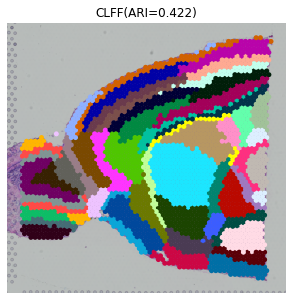

In [ ]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, img_key="hires", color=["DESTCLU"], title='CLFF(ARI=%.3f)'%ari, legend_loc=None, frameon=False,size=1.8,show=False)
plt.savefig("./CLFF_MouseBrain.pdf")